# Harmonization Pipeline Development
This temporary notebook is being used to develop the python and R pipeline used for harmonizing multisite MRI data.

## Import required modules

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

In [2]:
# Set up ipywidgets for interactive chart.
!jupyter nbextension enable --py widgetsnbextension
import ipywidgets as widgets
from ipywidgets import interact, fixed

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Function Definitions

### Function for Effect Size Calculation

In [3]:
# Function to compute effect sizes
# Based on method in Nakagawa, S. and I.C. Cuthill. (2007). Biol. Rev. 82. pp. 591-605.
# FORMATTING!!!!!
import math

def cohensd(t, df, n1, n2):
    d = ( t * (n1+n2) ) / (math.sqrt(n1*n2) * math.sqrt(df))
    se = math.sqrt( ((n1+n2-1)/(n1+n2-3)) * ( (4/(n1+n2)) * (1 + (d**2)/8) ))
    return {'d': d, 'se': se}

### Functions to Visualize the Data

In [4]:
# Plot distributions of the data by subset. These are meant to be overlaid, so just show the KDE.
def plot_distributions(data, subset_col, display_col):
    for sub in data[subset_col].unique():
        subset=data[data[subset_col] == sub]
        sns.distplot(subset[display_col],hist=False, kde=True, label=sub)

In [5]:
# Plot distributions, using stacked violin plots, split by the values in y.
def plot_stacked_dists(x, y, data, scale = 'count'):
    # Plot the distributions of ages across all sites. Extra hue_class column is a hacky solution to get seaborn 
    # to display half a violin plot.
    plt.figure()
    sns.set(style = 'whitegrid')
    vp_data = pd.DataFrame({'idx': data.index, x: data[x], y: data[y], 'hue_class': 0})
    vp_data['hue_class'].loc[-1] = 999
    ax_vp = sns.violinplot(y = y, x = x, data = vp_data, hue = 'hue_class', split = True, scale = scale)
    ax_vp.legend().remove()
    plt.show()

In [6]:
# Function to plot original and harmonized distributions together, by site.
def plot_dual_distributions(x, y, data_unharmonized, data_harmonized, scale = 'count'):
    # Plots two distibutions (e.g. harmonized and unharmonized data) as the two halves of stacked violin plots.
    plt.figure(figsize = (12,8))
    vp_data = pd.DataFrame({x: data_unharmonized[x], y: data_unharmonized[y], 'Legend': 'Unharmonized'})
    vp_data = vp_data.append(pd.DataFrame({x: data_harmonized[x], y: data_harmonized[y], 'Legend': 'Harmonized'}))
    ax_h_uh = sns.violinplot(y = y, x = x, data = vp_data, hue = 'Legend', split = True, scale = scale)
    #ax_h_uh.legend().remove()
    plt.show()

In [7]:
# Plot a panel of figures useful for quick data exploration and verification.
def plot_panel(nucleus, data1, data2):
    plt.figure()
    fig, axes = plt.subplots(ncols=2, nrows = 2, figsize = (13,4))
    plt.subplots_adjust(wspace = 0.5)
    
    # Plot nucleus volume by Age and TBV: data1
    sns.scatterplot('Age', nucleus, data = data1, hue = "DX", ax=axes[0,0])
    sns.regplot('Age', nucleus, data = data1, scatter = False, ax=axes[0,0])
    sns.scatterplot('TBV', nucleus, data = data1, hue = "DX", ax=axes[0,1])
    sns.regplot('TBV', nucleus, data = data1, scatter = False, ax=axes[0,1])
    
    # Plot nucleus volume by Age and TBV: data2
    sns.scatterplot('Age', nucleus, data = data2, hue = "DX", ax=axes[1,0])
    sns.regplot('Age', nucleus, data = data2, scatter = False, ax=axes[1,0])
    sns.scatterplot('TBV', nucleus, data = data2, hue = "DX", ax=axes[1,1])
    sns.regplot('TBV', nucleus, data = data2, scatter = False, ax=axes[1,1])
    
    # Plot the two distributions together
    plot_dual_distributions(x=nucleus, y = 'Site', data_unharmonized = data1, data_harmonized = data2, scale = 'count')

In [8]:
# Function to plot fitted values against residuals
# This relies on internal structure of the models. For now, it's the same for the linear regression and linear mixed models.
#def plot_fitted_vs_residual(models, ex_data, x_fitted_col, y_resid_col, display_col, hue_col, title_add = None):
def plot_fitted_vs_residual(models, ex_data, display_col, hue_col, title_add = None):
    plt.figure(figsize = (12,8))
    fitted_y = models[display_col].fittedvalues
    resid = models[display_col].resid
    # The following is not ideal. Need to revisit this solution.
    fit_resid_df = pd.DataFrame({'Residual': resid, 'Fitted_Value': fitted_y, 'Site': ex_data['Site'], 'DX': ex_data['DX']})
    ax = sns.scatterplot(fitted_y, resid, hue = hue_col, data=fit_resid_df)
    ax.set_title('Fitted vs. Residual Plot for ' + display_col + title_add)
    ax.set(xlabel = 'Fitted', ylabel = 'Residual')
    ax.legend().remove()
    plt.show()  

## Read data and drop rows with missing values for age, examine structure

In [10]:
data = pd.read_csv("../data/data_trimmed_allsites.csv", index_col=0)
#data = pd.read_csv("../data/data_trimmed.csv", index_col=0)

# Age is missing in some rows, but is needed for modelling. Drop those rows
complete_rows = data['Age'].notna()
NA_rows = ~complete_rows
data = data[complete_rows]
print('{} rows, {} features, {} rows dropped due to NA'.format(data.shape[0], data.shape[1], sum(NA_rows)))
print('Features: {}'.format(data.columns))
print('{} unique sites: {}'.format(data['Site'].unique().shape[0], data['Site'].unique()))

993 rows, 35 features, 13 rows dropped due to NA
Features: Index(['AAL_ID', 'Subject_ID', 'Site_ID', 'Site', 'Site_combined', 'CIVET_ID',
       'Subject', 'Project', 'DX_Group', 'DX', 'Age', 'Sex', 'Sex_edit',
       'Group', 'FIQ', 'VIQ', 'PIQ', 'FINAL_MOTION_QC', 'L_thal', 'R_thal',
       'L_GP', 'R_GP', 'L_str', 'R_str', 'L_str_vol', 'L_GP_vol', 'L_thal_vol',
       'R_str_vol', 'R_GP_vol', 'R_thal_vol', 'CSF', 'GM', 'WM', 'TBV',
       'QC_Notes'],
      dtype='object')
8 unique sites: ['IoP' 'Cambridge' 'TORONTO' 'ABIDEII_NYU' 'ABIDE_NYU' 'ABIDEII_OHSU'
 'ABIDE_OHSU' 'ABIDE_UM']


## Mask features that failed segmentation QC

In [68]:
# QC columns are of the form L_str. Volume data is in L_str_vol
QC_cols = ['L_str', 'L_GP', 'L_thal', 'R_str', 'R_GP', 'R_thal']
features = [QCc + '_vol' for QCc in QC_cols]

QC_passed = data[QC_cols] > 0.5

feats = data[features]
feats[QC_passed > 0.5]
mask = QC_passed > 0.5
feats[mask]
a = pd.DataFrame({1:2,3,4},{22:100,10,10})
#np.multiply(data[features], QC_passed)
#masked_features

ValueError: Shape of passed values is (3, 1), indices imply (1, 1)

## Examine the distributions

count    993.000000
mean      18.175196
std        9.801495
min        4.000000
25%       11.000000
50%       15.300000
75%       24.000000
max       65.000000
Name: Age, dtype: float64


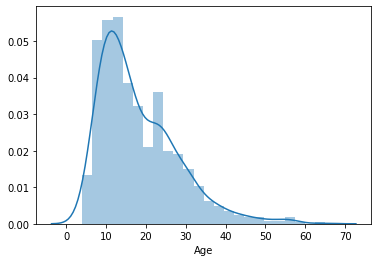

In [10]:
print(data.Age.describe())
sns.distplot(data['Age'])

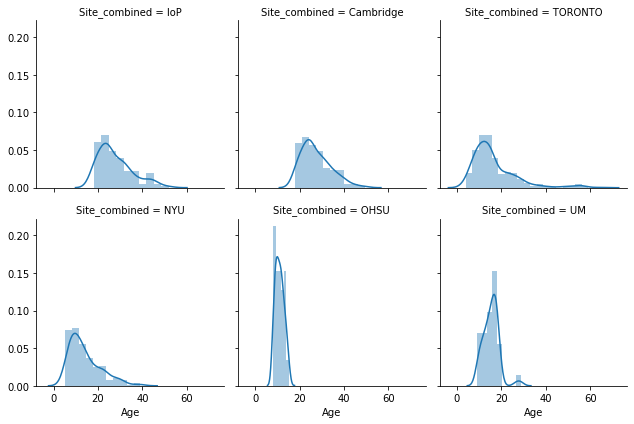

In [11]:
age_fg = sns.FacetGrid(data,col='Site_combined',col_wrap=3)
age_fg.map(sns.distplot, "Age")

In [12]:
data['L_str_vol_norm'] = data['L_str_vol']/data['TBV']
data[['L_str_vol','TBV','L_str_vol_norm']]

,L_str_vol,TBV,L_str_vol_norm
0,10423.00,3120329.80,0.003340
1,12433.00,3540926.04,0.003511
2,11619.00,3608836.80,0.003220
3,11623.00,4181290.36,0.002780
4,9740.00,3036437.24,0.003208
...,...,...,...
1001,7164.21,2022101.46,0.003543
1002,11313.40,3138960.95,0.003604
1003,9955.40,3196888.60,0.003114
1004,11409.60,2876925.68,0.003966


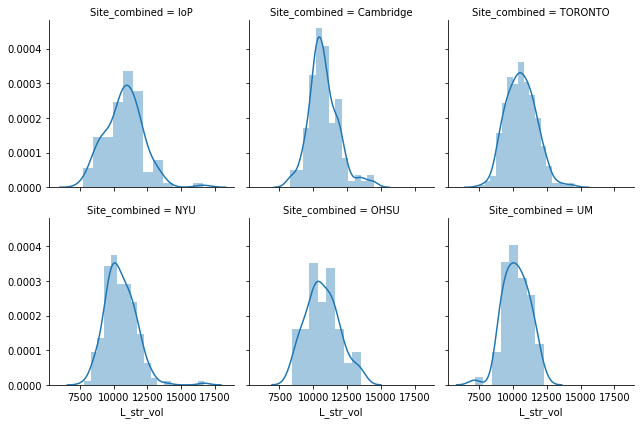

In [13]:
strvol_fg = sns.FacetGrid(data,col='Site_combined',col_wrap=3)
strvol_fg.map(sns.distplot,"L_str_vol")

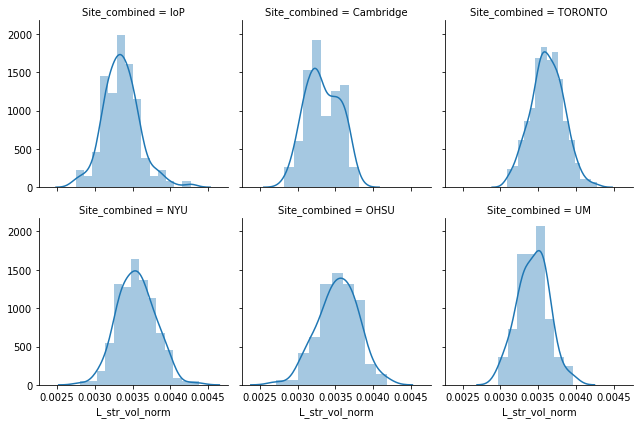

In [14]:
strvol_fg = sns.FacetGrid(data,col='Site_combined',col_wrap=3)
strvol_fg.map(sns.distplot,"L_str_vol_norm")

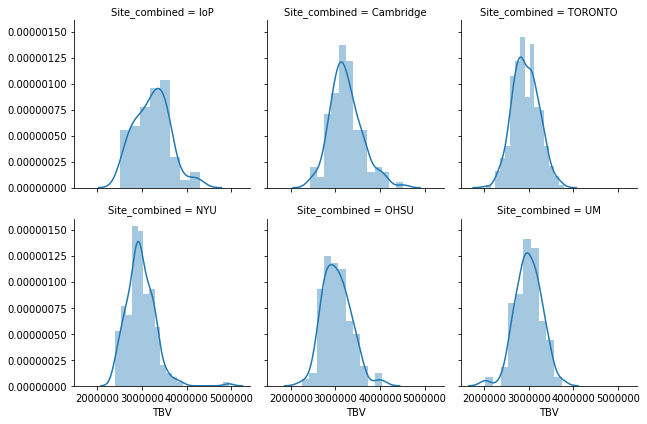

In [15]:
strvol_fg = sns.FacetGrid(data,col='Site_combined',col_wrap=3)
strvol_fg.map(sns.distplot,"TBV")

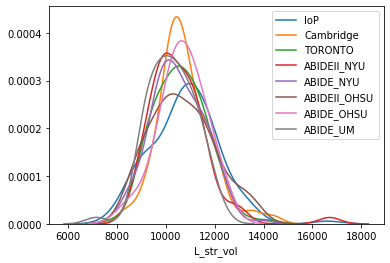

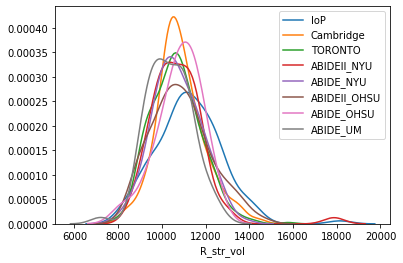

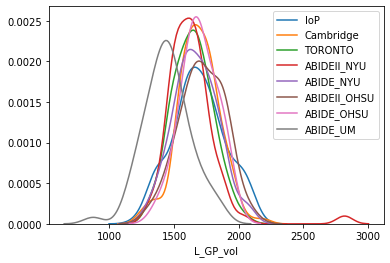

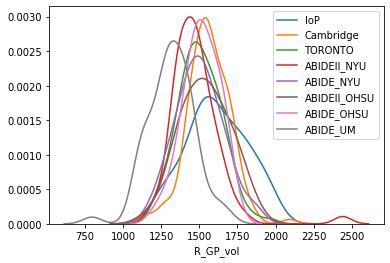

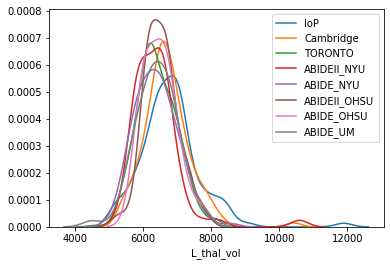

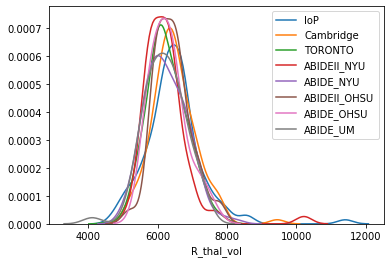

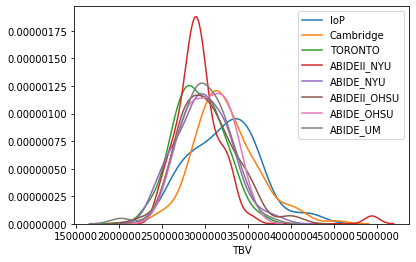

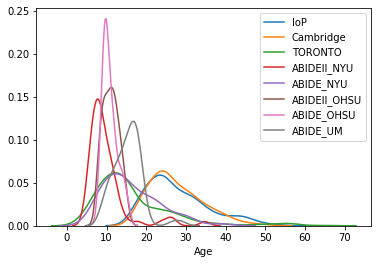

In [16]:
for struct in ['L_str_vol', 'R_str_vol', 'L_GP_vol', 'R_GP_vol', 'L_thal_vol', 'R_thal_vol','TBV','Age']:
    plt.figure()
    plot_distributions(data, "Site", struct)


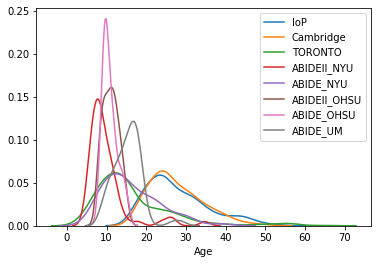

In [17]:
plot_distributions(data, "Site", "Age")

## Harmonize subcortical volume data using NeuroComBat

In [18]:
# Map site IDs to integers, as required by neuroCombat()
sites = data['Site'].unique()
site_dict = dict(zip(sites, range(1, len(sites)+1)))
data['Site_no'] = data['Site'].map(site_dict)
#data['Site'].map(site_dict)

# Indicate the features we want to harnomize
features = ['L_str_vol', 'L_GP_vol', 'L_thal_vol', 'R_str_vol', 'R_GP_vol', 'R_thal_vol']

harmonized_features = nc.neuroCombat(data[features].transpose(), covars=data[['Site_no', 'Age', 'DX', 'Sex']], batch_col='Site_no', categorical_cols=[], continuous_cols=[]).transpose()
harmonized_features = pd.DataFrame(harmonized_features)

# Add the column names and covariates back to the harmonized feature volumes
# ComBat doesn't change the order of the rows (I don't think! Verify)
harmonized_features.columns = features
harmonized_features['Site'] = data['Site']
harmonized_features['Age'] = data['Age']
harmonized_features['TBV'] = data['TBV']
harmonized_features['Sex'] = data['Sex']
harmonized_features['DX'] = data['DX']


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


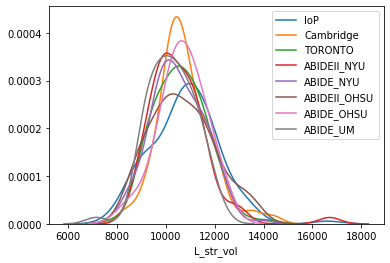

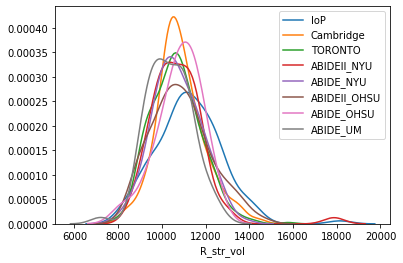

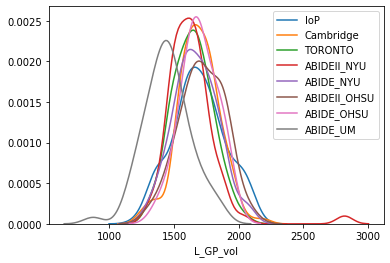

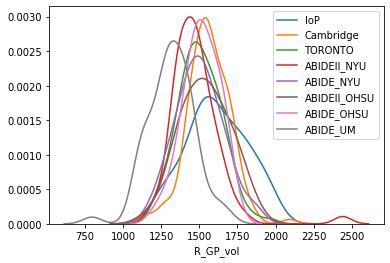

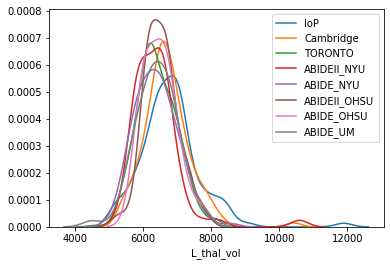

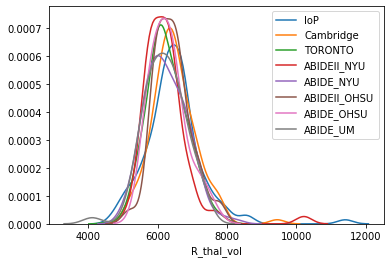

In [19]:
for struct in ['L_str_vol', 'R_str_vol', 'L_GP_vol', 'R_GP_vol', 'L_thal_vol', 'R_thal_vol']:
    plt.figure()
    plot_distributions(data, "Site", struct)

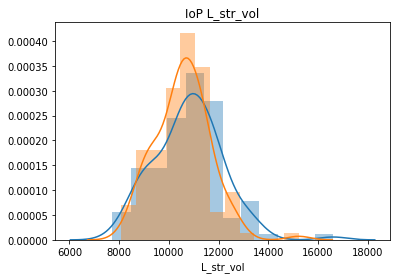

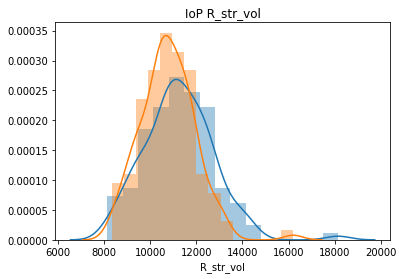

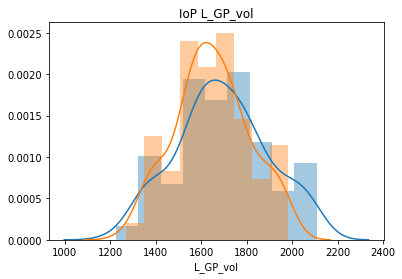

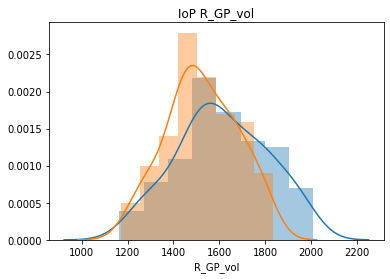

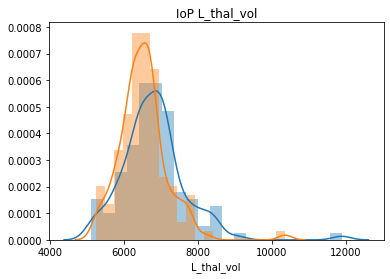

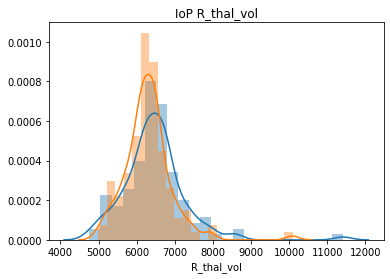

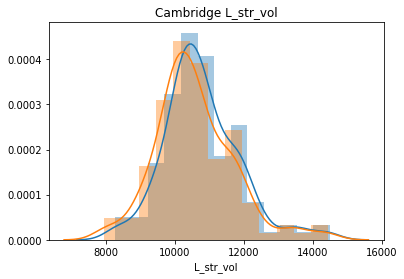

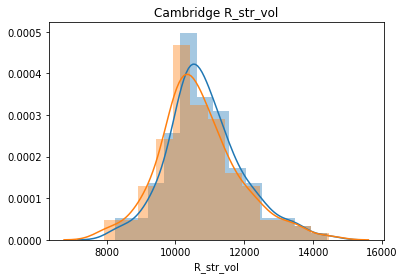

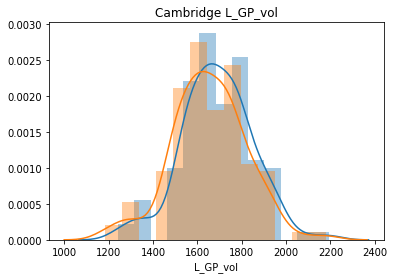

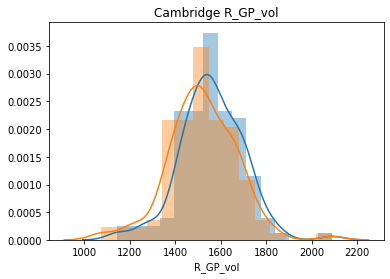

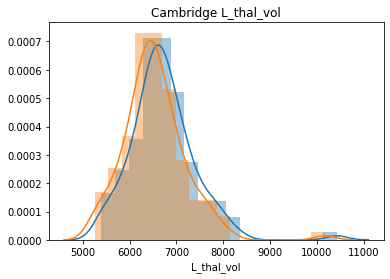

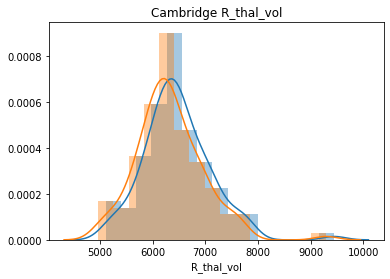

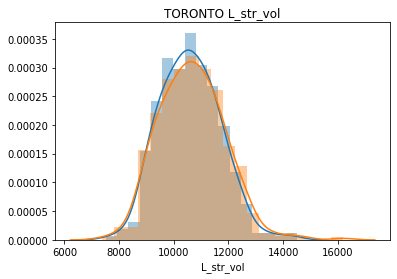

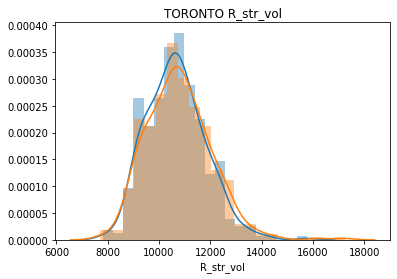

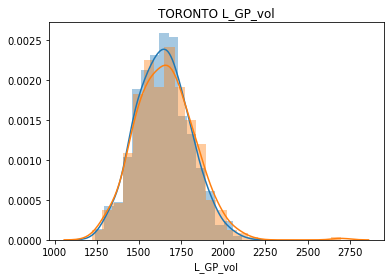

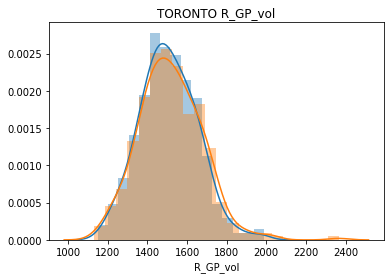

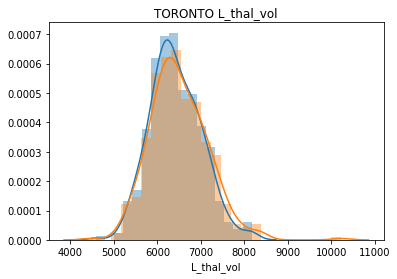

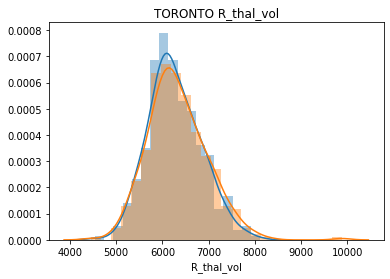

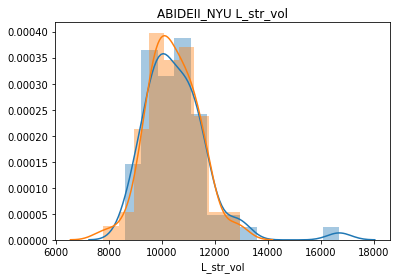

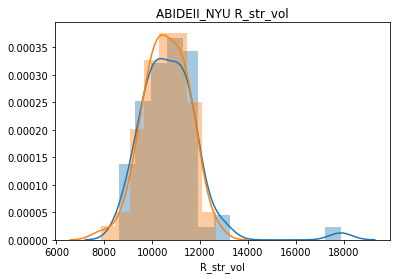

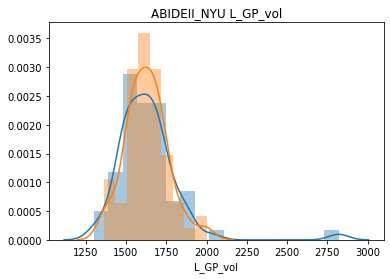

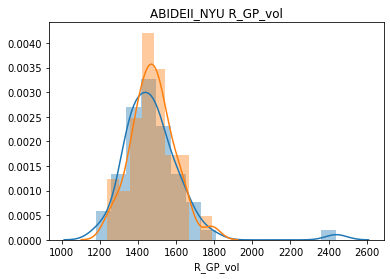

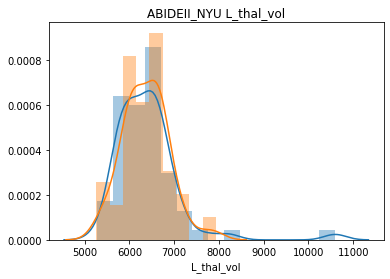

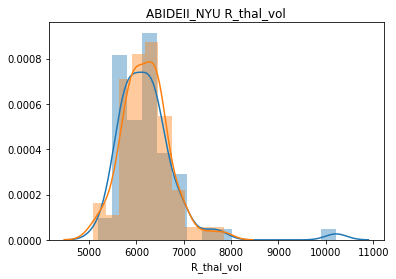

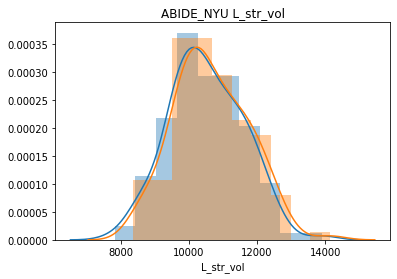

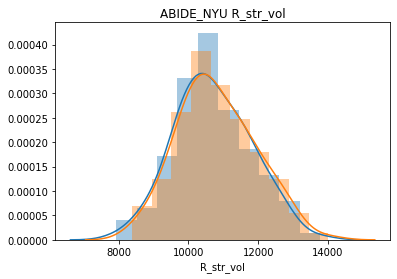

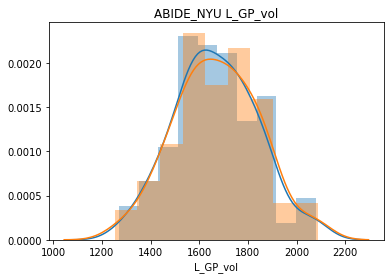

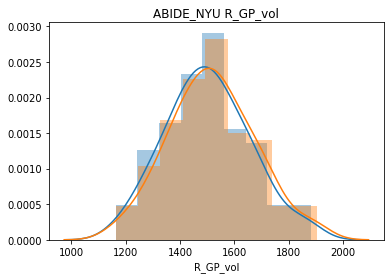

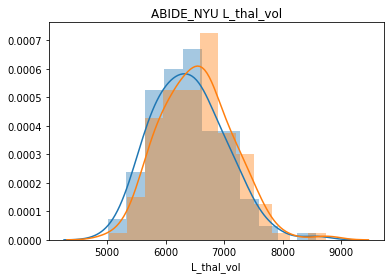

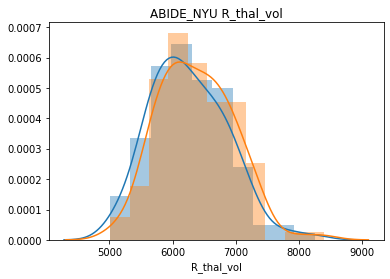

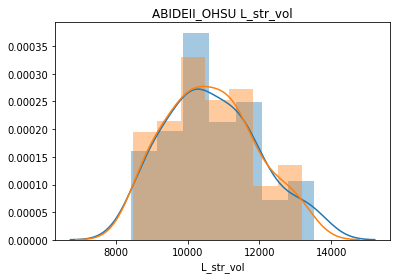

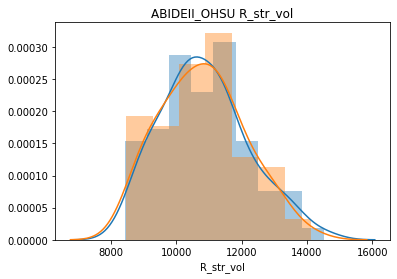

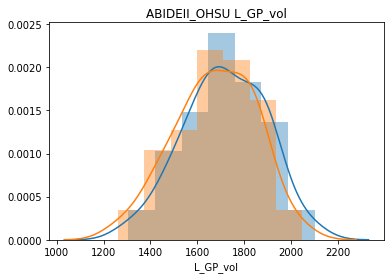

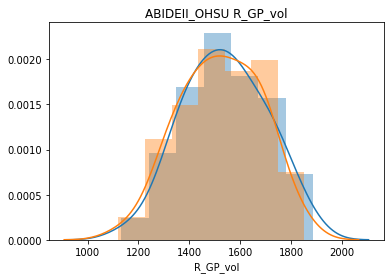

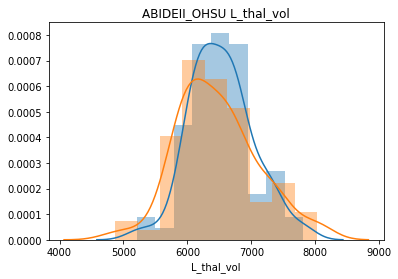

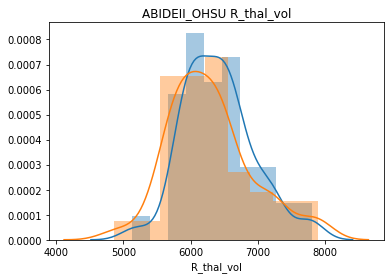

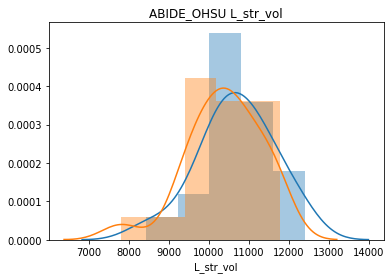

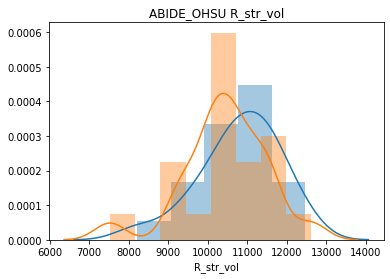

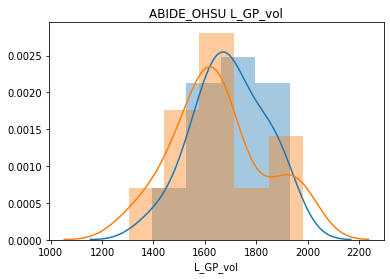

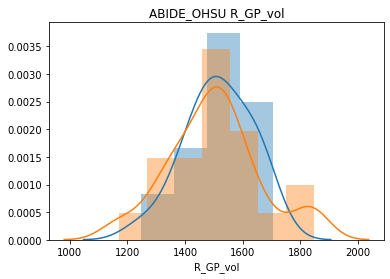

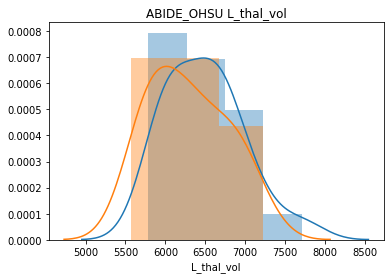

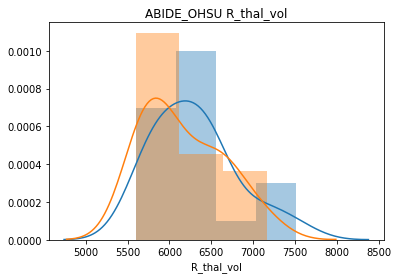

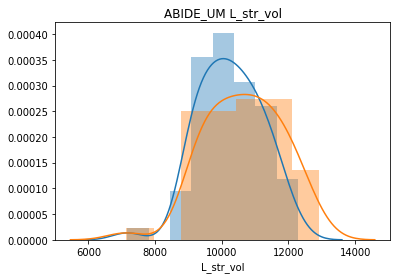

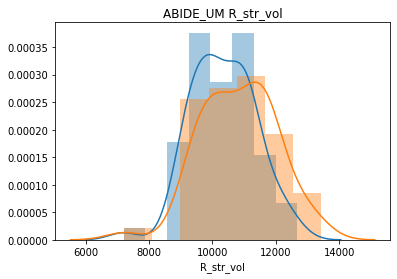

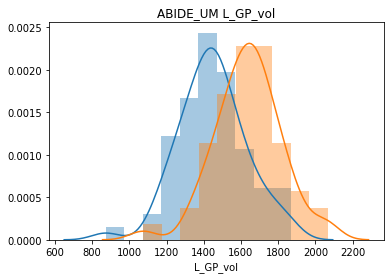

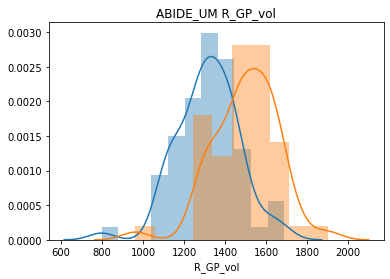

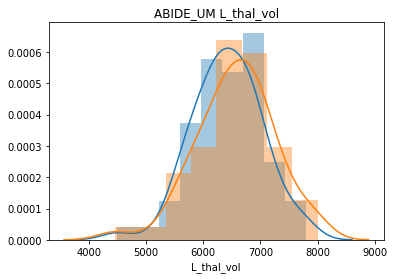

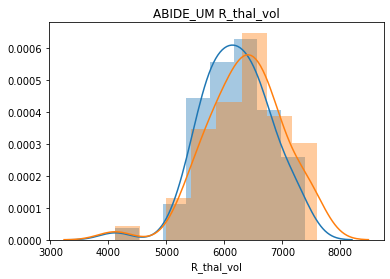

In [20]:
for site in sites:
    for struct in ['L_str_vol', 'R_str_vol', 'L_GP_vol', 'R_GP_vol', 'L_thal_vol', 'R_thal_vol']:
        plt.figure()
        ax = sns.distplot(data[data['Site']==site][struct],hist=True,kde=True,label='Original')
        sns.distplot(harmonized_features[harmonized_features['Site'] == site][struct],hist=True,kde=True,label='Harmonized')
        ax.set_title(site + " " + struct)
        plt.show()

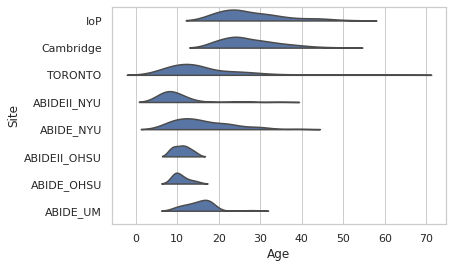

In [21]:
plot_stacked_dists(x = 'Age', y = 'Site', data = data)

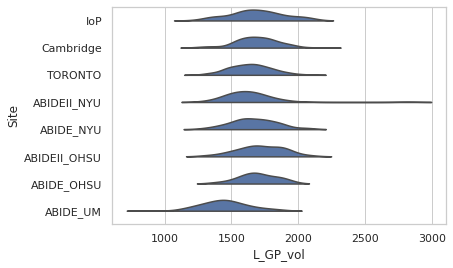

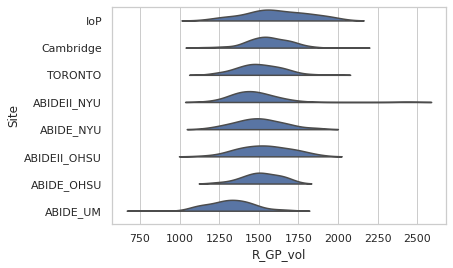

In [22]:
plot_stacked_dists(x = 'L_GP_vol', y = 'Site', data = data)
plot_stacked_dists(x = 'R_GP_vol', y = 'Site', data = data)


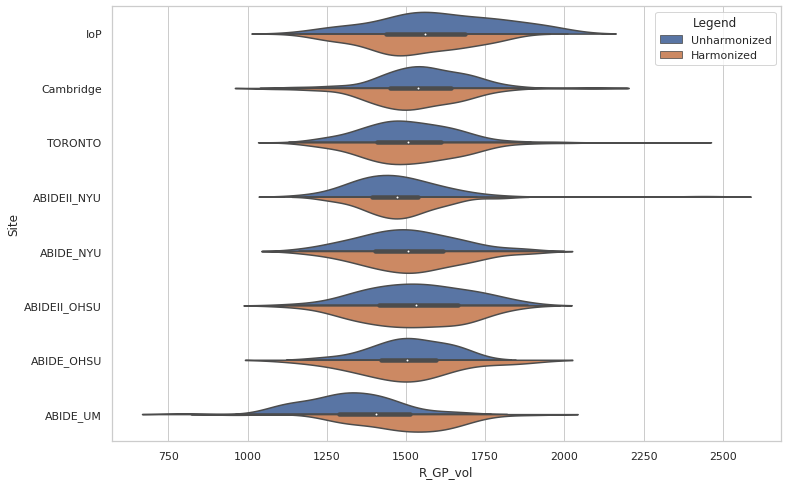

In [23]:
plot_dual_distributions(x = 'R_GP_vol', y = 'Site', data_unharmonized = data, data_harmonized = harmonized_features)
# Can I do this in a FacetGrid???

### Determine Effect of Diagnosis: Linear Models with ComBat Harmonized Data
So, now I've got unharmonized and ComBat harmonized data. Should be able to run linear models on the ComBat data to get differences between ASD and Controls on structure volumes. These differences will be beta values. Following Radua et al. (2020), can convert those to Hedges' _g_.

In [24]:
# Linear regression on ComBat harmonized data
from statsmodels.formula.api import ols

models = pd.Series(dtype='object')
model_params = pd.Series(dtype = 'object')
model_es = pd.Series(dtype = 'object')

for nucleus in harmonized_features.columns[:-5]:        # Don't include last (covariate) columns
    models[nucleus] = ols(formula = nucleus + ' ~ DX + Age + Sex + TBV', data = harmonized_features).fit()
    print(models[nucleus].summary())
    model_params[nucleus] = models[nucleus].params

    # Get effect size, being sure to drop rows with NA for age.
    n_control = sum(data['DX'] == 'Control')
    n_ASD = models[nucleus].nobs - n_control
    model_es[nucleus] = cohensd(t  = models[nucleus].tvalues['DX[T.Control]'], 
                                df = models[nucleus].df_resid, 
                                n1 = n_control,
                                n2 = n_ASD)

print("Effect Sizes:")
print(model_es)

                            OLS Regression Results                            
Dep. Variable:              L_str_vol   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     66.04
Date:                Tue, 23 Jun 2020   Prob (F-statistic):           1.87e-49
Time:                        15:48:35   Log-Likelihood:                -8159.5
No. Observations:                 978   AIC:                         1.633e+04
Df Residuals:                     973   BIC:                         1.635e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6442.1367    381.411     16.890

#### Questions
1. What am I using for significance? The F-stat probability? The probability for the co-efficients?
2. How am I correcting these for multiple comparisons?

#### Next Steps
1. Pull the co-efficients out of the models and compute effect sizes.
2. Store which ones are significant.
3. Do some sort of multiple comparisons correction.
4. Try this with TBV as a covariate, as well.

#### Diagnostics
Check the residual vs. fitted values plots.

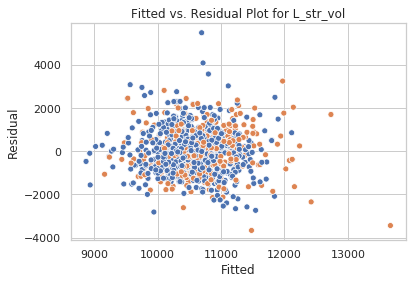

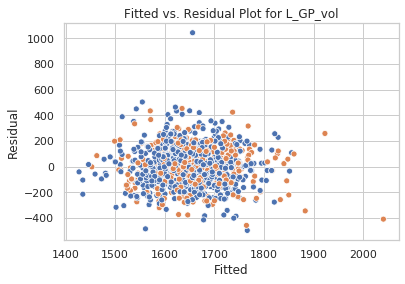

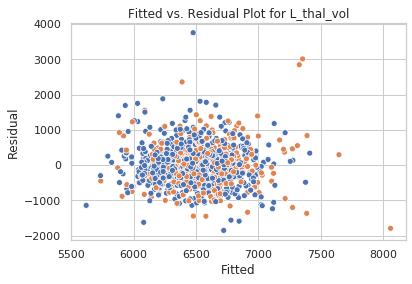

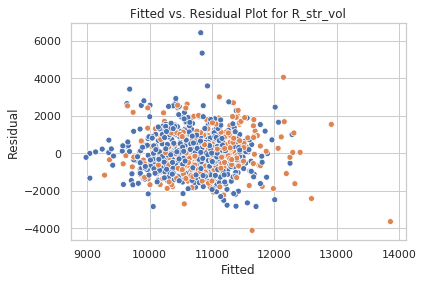

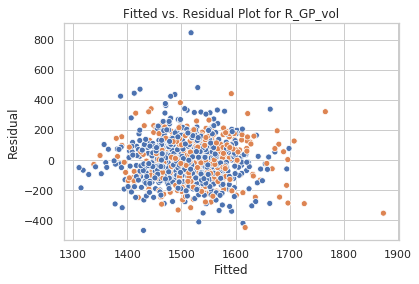

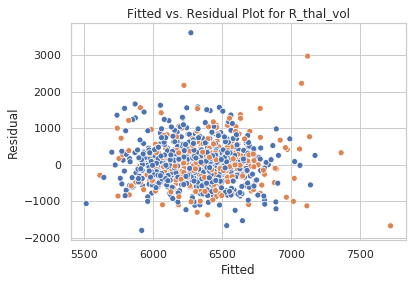

In [25]:
for nucleus in harmonized_features.columns[:-5]:        # Don't include last (covariate) columns
    fitted_y = models[nucleus].fittedvalues
    resid = models[nucleus].resid
    plt.figure()
    # Fix this. For now, it relies on the fitted values being in the same order as the unfitted raw df.
    ax = sns.scatterplot('Fitted_Value', 'Residual', hue = 'DX', data={'Residual': resid, 'Fitted_Value': fitted_y, 'Site': harmonized_features['Site'], 'DX': harmonized_features['DX']})
    #ax = sns.scatterplot('Fitted_Value', 'Residual', data={'Residual': resid, 'Fitted_Value': fitted_y})
    ax.set_title('Fitted vs. Residual Plot for ' + nucleus)
    ax.set(xlabel = 'Fitted', ylabel = 'Residual')
    ax.legend().remove()
    plt.show()

Ok, do the plots above make sense? The thalamus plots are interesting. I guess if beta is high, it makes sense: one group will be at the intercept, plus a term for age, while the other will be intercept plus beta, plus age. So, when I look into the model, I should see a higher DX beta for thalamus than for the other structures, and/or a lower age beta. (?)
 * No, they don't seem that different. This would be a question for a mentor! Maybe check in with Gabe? Or someone else in the lab?

### Check the scatter plots of the volumes by diagnosis for each site
 * Is there a way to dynamically do this, adding and removing regressors? Prob not, you'd need to be adding dimensions.
 

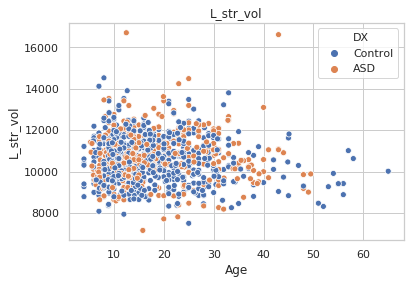

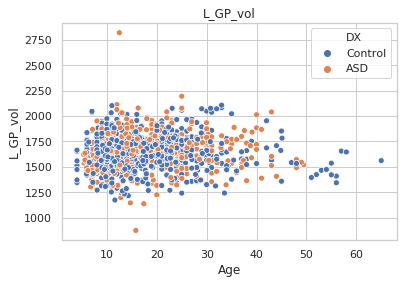

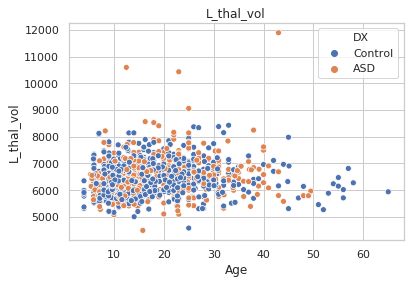

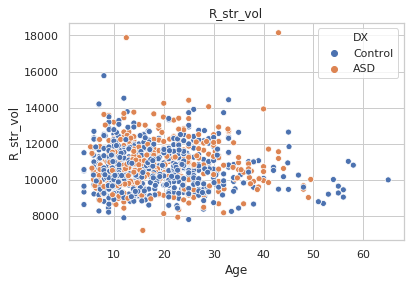

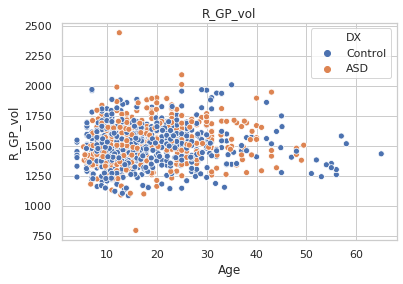

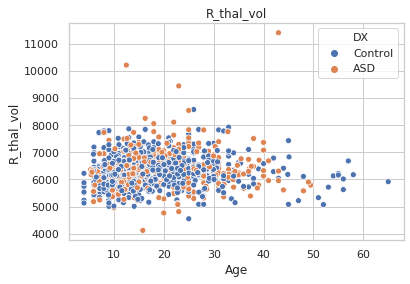

In [26]:
for nucleus in features:
    plt.figure()
    ax = sns.scatterplot('Age', nucleus, data = data, hue = "DX")
    ax.set_title(nucleus)
    plt.show()


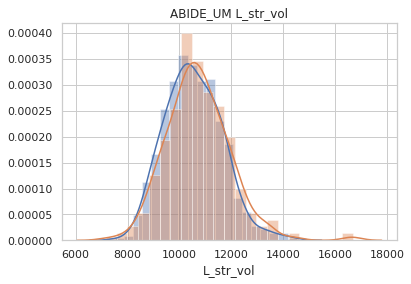

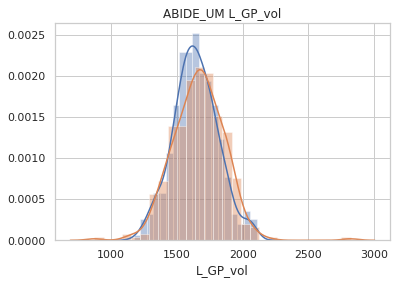

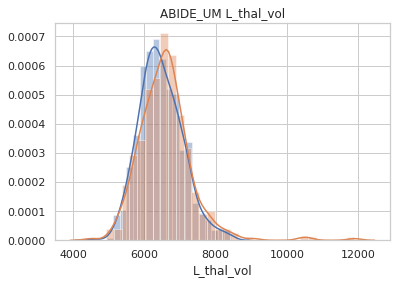

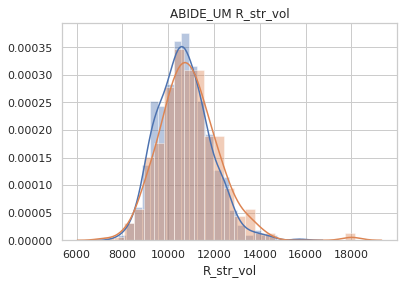

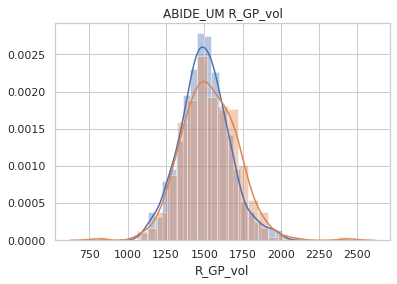

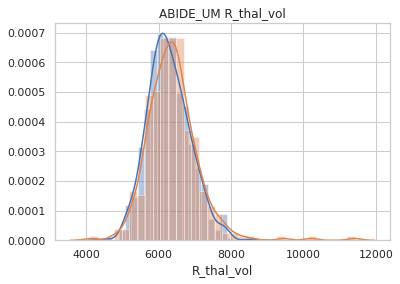

In [27]:
for struct in features:
    plt.figure()
    ax = sns.distplot(data[data['DX'] == 'Control'][struct],hist=True,kde=True,label='Control')
    sns.distplot(data[data['DX'] == 'ASD'][struct],hist=True,kde=True,label='ASD')
    ax.set_title(site + " " + struct)
    plt.show()

In [28]:
interact(plot_dual_distributions, 
         x = features, 
         y = fixed('Site'), 
         data_unharmonized = fixed(data), 
         data_harmonized = fixed(harmonized_features), 
         scale = fixed('count'))

interactive(children=(Dropdown(description='x', options=('L_str_vol', 'L_GP_vol', 'L_thal_vol', 'R_str_vol', '…

<function __main__.plot_dual_distributions(x, y, data_unharmonized, data_harmonized, scale='count')>

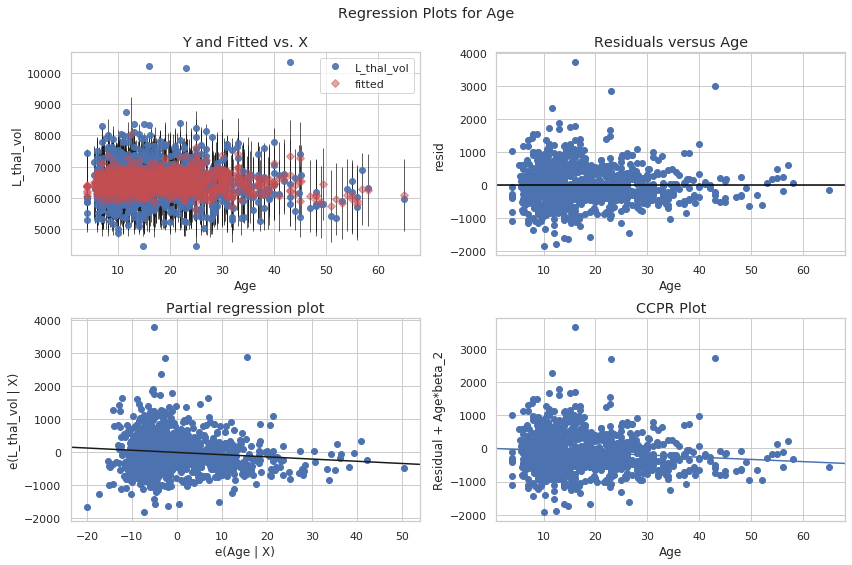

In [29]:
import statsmodels.api as sm
fig = plt.figure(figsize = (12,8))
fig = sm.graphics.plot_regress_exog(models['L_thal_vol'], 'Age', fig=fig)

In [30]:
models['L_thal_vol'].model.exog_names

['Intercept', 'DX[T.Control]', 'Age', 'Sex', 'TBV']

In [31]:
# Plot fitted values vs. residuals of ComBat harmonized data

interact(plot_fitted_vs_residual, 
         models = fixed(models), 
         ex_data = fixed(harmonized_features),
#         x_fitted_col = fixed('Fitted_Value'), 
#         y_resid_col = fixed('Residual'), 
         display_col = features, 
         hue_col = ['DX', 'Site'],
         title_add = fixed(' ComBat Harmonized'))

interactive(children=(Dropdown(description='display_col', options=('L_str_vol', 'L_GP_vol', 'L_thal_vol', 'R_s…

<function __main__.plot_fitted_vs_residual(models, ex_data, display_col, hue_col, title_add=None)>

## Compute Linear Regression on Unharmonized Data

In [32]:
# Linear regression on unharmonized data
models_unh = pd.Series(dtype='object')
model_unh_params = pd.Series(dtype = 'object')
model_unh_es = pd.Series(dtype = 'object')

for nucleus in features:
    models_unh[nucleus] = ols(formula = nucleus + ' ~ DX + Age + Sex + TBV + Site', data = data).fit()
    print(models_unh[nucleus].summary())
    model_unh_params[nucleus] = models_unh[nucleus].params
    
    # Get effect size, being sure to drop rows with NA for age.
    n_control = sum(data['DX'] == 'Control')
    n_ASD = models_unh[nucleus].nobs - n_control
    model_unh_es[nucleus] = cohensd(t  = models_unh[nucleus].tvalues['DX[T.Control]'], 
                                    df = models_unh[nucleus].df_resid, 
                                    n1 = n_control,
                                    n2 = n_ASD)

print("Effect Sizes:")
print(model_unh_es)

                            OLS Regression Results                            
Dep. Variable:              L_str_vol   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     183.6
Date:                Tue, 23 Jun 2020   Prob (F-statistic):          4.49e-229
Time:                        15:48:46   Log-Likelihood:                -7837.8
No. Observations:                 991   AIC:                         1.570e+04
Df Residuals:                     979   BIC:                         1.576e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2318.7480 

                            OLS Regression Results                            
Dep. Variable:             R_thal_vol   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     191.5
Date:                Tue, 23 Jun 2020   Prob (F-statistic):          4.38e-235
Time:                        15:48:46   Log-Likelihood:                -7231.0
No. Observations:                 991   AIC:                         1.449e+04
Df Residuals:                     979   BIC:                         1.454e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1635.5634 

## Fitted Values vs. Residuals Unharmonized Data

In [33]:
# Plot fitted values vs. residuals of unharmonized data

interact(plot_fitted_vs_residual, 
         models = fixed(models_unh), 
         ex_data = fixed(data),
         x_fitted_col = fixed('Fitted_Value'), 
         y_resid_col = fixed('Residual'), 
         display_col = features, 
         hue_col = ['DX', 'Site'],
         title_add = fixed(' Unharmonized'))

interactive(children=(Dropdown(description='display_col', options=('L_str_vol', 'L_GP_vol', 'L_thal_vol', 'R_s…

<function __main__.plot_fitted_vs_residual(models, ex_data, display_col, hue_col, title_add=None)>

## Linear Mixed Model on the Raw Data
An alternative analysis is to run a linear mixed model on the raw (unharmonized) data, with site as a random effect. I could do this and then plot effect sizes, confidence intervals, as well as do the fitted vs. residual plots.

***Note: The linear mixed model function here drops rows with missing data. Check to verify what python ComBat does! If it is not the same, then differences could be attibutable to different missing value handling.***

In [34]:
# Code in this cell based on https://www.statsmodels.org/stable/mixed_linear.html
# and https://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html
# import statsmodels.api as sm
import statsmodels.formula.api as smf

lm_models = pd.Series(dtype='object')
lm_model_params = pd.Series(dtype = 'object')
lm_model_es = pd.Series(dtype = 'object')

for nucleus in features:
    lm_models[nucleus] = smf.mixedlm(nucleus + " ~ DX + Age + Sex + TBV", data, groups = data["Site"], missing='drop').fit()
    lm_model_params[nucleus] = lm_models[nucleus].params
    
    # Get effect size, being sure to drop rows with NA for age.
    n_control = sum(data['DX'] == 'Control')
    n_ASD = lm_models[nucleus].nobs - n_control
    lm_model_es[nucleus] = cohensd(t  = lm_models[nucleus].tvalues['DX[T.Control]'], 
                          df = lm_models[nucleus].df_resid, 
                          n1 = n_control,
                          n2 = n_ASD)
    
    print(lm_models[nucleus].summary())

print("Effect Sizes:")
print(lm_model_es)

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   L_str_vol  
No. Observations:   991       Method:               REML       
No. Groups:         8         Scale:                438789.8492
Min. group size:    21        Log-Likelihood:       -7841.1604 
Max. group size:    390       Converged:            Yes        
Mean group size:    123.9                                      
---------------------------------------------------------------
                Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------
Intercept      2301.600  275.665  8.349 0.000 1761.306 2841.894
DX[T.Control]    34.213   45.950  0.745 0.457  -55.848  124.274
Age             -21.181    2.602 -8.140 0.000  -26.281  -16.081
Sex             -35.528   51.823 -0.686 0.493 -137.099   66.043
TBV               0.003    0.000 38.218 0.000    0.003    0.003
Group Var     28396.448   25.945                     

In [35]:
# Plot fitted values vs. residuals of Linear Mixed Model-modelled data

interact(plot_fitted_vs_residual, 
         models = fixed(lm_models), 
         ex_data = fixed(data),
         #x_fitted_col = fixed('Fitted_Value'), 
         #y_resid_col = fixed('Residual'), 
         display_col = features, 
         hue_col = ['DX', 'Site'],
         title_add = fixed(' Linear Mixed Model'))

interactive(children=(Dropdown(description='display_col', options=('L_str_vol', 'L_GP_vol', 'L_thal_vol', 'R_s…

<function __main__.plot_fitted_vs_residual(models, ex_data, display_col, hue_col, title_add=None)>

In [36]:
fig = plt.figure(figsize = (12,8))
fig = sm.graphics.plot_regress_exog(lm_models['L_thal_vol'], 'DX[T.Control]', fig=fig)


AttributeError: 'MixedLM' object has no attribute 'weights'

<Figure size 864x576 with 0 Axes>

## Meta-Analysis
Haven't coded this in Python yet, but the plan is to, for each site and each structure:
 1. Run a linear regression structure ~ DX + Age
 2. Compute Hedges' _g*_ effect sizes for each structure and each site, of DX
 3. Use a Random-Effects Meta-Analysis to combine the effects from each site
 
___Note:___ _I can't seem to find a mature python package for meta-analysis. I may have to code it myself. Shouldn't be too hard._

In [ ]:
tm = models['L_str_vol']
tmm = tm.model
tmm.endog.shape[0]
tms = tm.summary()
print(tm.tvalues['DX[T.Control]'])
print(tm.df_resid)
tmm.exog

## Method Comparisons
Compare the three methods on:
 1. Robustness: do all three methods show the same results?
 2. Sensitivity: are all three methods equally sensitive / do they all detect the same effects?
 
Visualization possibilities:
 1. Forest plots by structure, showing the effect sizes of all three effects, after Radua, et al. (preprint 2020)

In [ ]:
interact(plot_panel, nucleus = features, data1 = fixed(data), data2=fixed(harmonized_features))

In [ ]:
ext_features = features + ['TBV']
print(ext_feat)
norm_unh = data[features].div(data['TBV'].iloc[0])
norm_unh['Site'] = data['Site']
norm_unh['DX'] = data['DX']
norm_unh['Age'] = data['Age']
norm_unh['TBV'] = data['TBV']

norm_h = harmonized_features[features].div(harmonized_features['TBV'].iloc[0])
norm_h['Site'] = data['Site']
norm_h['DX'] = data['DX']
norm_h['Age'] = data['Age']
norm_h['TBV'] = data['TBV']

interact(plot_panel, nucleus = ext_features, data1 = fixed(norm_unh), data2=fixed(norm_h))
type(norm_unh)

# To Do
 1. Add references section
 2. Look up (Ross's? Greg's?) documentation strings and document functions
 3. Deal with missing values, and remove values based on QC.
 4. Make the code more "Pythonic" - there are places where I'm not using dataframes and series in quite the optimal way.
 5. Add meta-analysis code for another option - it's another ENIGMA technique, with mature packages available in R, but not in Python.
 6. Create an interactive figure that shows the effect of adding or removing terms from the model. Noticed some significant clustering in the residual vs. fitted plots by DX when TBV was taken out of the model. When added back in, the clustering disappeared. This was particularly evident in the thalamus.
 7. Check structures against TBV, and DX against TBV. The clustering in the thalamus (see above) was quite noticeable, and disappears when TBV is included in the model. Note that p values for DX move from ~ .05 to > .5 when TBV is included in the model. This suggests that any volumetric effect in the subcortical structures is largely driven by differences in TBV.
 * Consider, should I be harmonizing TBV as well?
 8. Plot the effect sizes and SEs.
 9. Open data, and package up with a full data file.
 10. Deal with collinearity in models, e.g. nucleus volume and TBV.

## In the future
 1. Have a look at metafor - can I reproduce some of it in a Python package? That would be a cool way to make a contribution. Could do it piecemeal. Discuss with Gabe.
 